In [12]:
import numpy as np
import keras
from keras.layers import Dense, Input
from keras.models import Model
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

## This is visualization about the raw data, exploratory analysis

In [14]:
path = './Files/Before_Feature_Engineering/'
data_C_part1 = pd.read_csv(path + 'data_C_part1.csv', low_memory=False)
data_C_part2 = pd.read_csv(path + 'data_C_part2.csv', low_memory=False)
data_D = pd.read_csv(path + 'data_D.csv', low_memory=False)

In [15]:
data_C_part1.columns

Index(['architectural_archetype', 'stories', 'soil_class', 'seismic_zone',
       'connection_system', 'Story', 'Direction', 'Wall', 'L cm', 'xi cm',
       'yi cm', 'D+0.25L', 'Story Area', 'Nail spacing [cm]',
       'Number sheathing panels', 'Number end studs', 'Total number studs',
       'HoldDown Model / ATS'],
      dtype='object')

In [16]:
data_C_part2.columns

Index(['architectural_archetype', 'stories', 'soil_class', 'seismic_zone',
       'connection_system', 'L cm_1_X_1.1', 'xi cm_1_X_1.1', 'yi cm_1_X_1.1',
       'L cm_1_X_1.2', 'xi cm_1_X_1.2',
       ...
       'xi cm_5_X_13.4', 'yi cm_5_X_13.4', 'L cm_5_Y_H.4', 'xi cm_5_Y_H.4',
       'yi cm_5_Y_H.4', 'L cm_5_Y_J.6', 'xi cm_5_Y_J.6', 'yi cm_5_Y_J.6',
       'Tx(s)', 'Ty(s)'],
      dtype='object', length=3619)

In [17]:
data_D.columns

Index(['architectural_archetype', 'stories', 'soil_class', 'seismic_zone',
       'connection_system', 'L cm_1_X_1.1', 'xi cm_1_X_1.1', 'yi cm_1_X_1.1',
       'Nail spacing [cm]_1_X_1.1', 'Number sheathing panels_1_X_1.1',
       ...
       'µy', 'CMR', 'SSF', 'ACMR', 'IO-ln θ', 'IO-β', 'LS-ln θ', 'LS-β',
       'CP-ln θ', 'CP-β'],
      dtype='object', length=9632)

This will help us determine which columns are categoricales and which ones are not.

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data
path = './Files/Before_Feature_Engineering/'
data_C_part1 = pd.read_csv(path + 'data_C_part1.csv', low_memory=False)
data_C_part2 = pd.read_csv(path + 'data_C_part2.csv', low_memory=False)
data_D = pd.read_csv(path + 'data_D.csv', low_memory=False)

# Rename column in data_C_part1
data_C_part1.rename(columns={'HoldDown Model / ATS': 'HD_ATS'}, inplace=True)

# Function to create and save plots
def create_and_save_plots(dataframe, dataframe_name, save_dir):
    sns.set_style("whitegrid")

    for i in dataframe.columns:
        # Get the value counts
        value_counts = dataframe[i].value_counts()

        # Create a bar plot for the value counts
        plt.figure(figsize=(10, 6))
        sns.barplot(x=value_counts.index, y=value_counts.values)

        # Adding title and labels
        plt.title(f'Value Counts of {i} in {dataframe_name}')
        plt.ylabel('Counts')
        plt.xlabel(f'{i} Values')

        # Save the plot to a file
        plt.savefig(f'{save_dir}{dataframe_name}_{i}_value_counts.png')

        # Close the plot to avoid display issues in some environments
        plt.close()

# Directory where plots will be saved
save_dir = './Files/Visualisation/Exploratory_Data_Analysis/'

# Create and save plots for each DataFrame
create_and_save_plots(data_C_part1, 'data_C_part1', save_dir)
#We don't need to do it for data_C_part2, since we only need to visualise for Tx and Ty that is alredy found in d
target_column_D = ['Ωx', 'Ωy', 'µx', 'µy', 'CMR', 'SSF', 'ACMR', 'IO-ln θ','IO-β','LS-ln θ','LS-β', 'CP-ln θ','CP-β']
target_column_C_2 = ['Tx(s)', 'Ty(s)']
columns = target_column_D + target_column_C_2
create_and_save_plots(data_D[columns], 'data_D', save_dir)


## This is visualization about how well the feature engineering works
We used mostly methods of feature engineering we predicting information D
Below are the methods we want to find out if they are useful

In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from pandas.api.types import is_numeric_dtype
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from pandas.api.types import is_numeric_dtype

def one_hot_encode_columns(df, columns):
    """
    One-hot encode specified columns in a DataFrame.

    :param df: The DataFrame to process.
    :param columns: A list of column names to be one-hot encoded.
    :return: The modified DataFrame and a list of new column indices.
    """
    original_columns = set(df.columns)
    for column in columns:
        encoded = pd.get_dummies(df[column], prefix=column)
        df = pd.concat([df, encoded], axis=1).drop(column, axis=1)
    new_columns = set(df.columns) - original_columns
    new_column_indices = [df.columns.get_loc(c) for c in new_columns]
    return df, new_column_indices

def scale_columns(df, scaler, columns):
    """
    Scale specified columns using the provided scaler.

    :param df: The DataFrame to process.
    :param scaler: Scaler instance (e.g., MinMaxScaler).
    :param columns: A list of column names to be scaled.
    :return: The modified DataFrame.
    """
    df[columns] = scaler.fit_transform(df[columns])
    return df

def most_common_ratio(series):
    """
    Calculate the ratio of the most common value in a Series.

    :param series: Pandas Series to analyze.
    :return: Ratio of the most common value.
    """
    return series.value_counts(normalize=True).iloc[0]

def remove_column_with_high_ratio(df, exclude_columns):
    """
    Remove columns with a high ratio of a single value.

    :param df: The DataFrame to process.
    :param exclude_columns: A list of column names to be excluded from processing.
    :return: The modified DataFrame.
    """
    threshold = 0.98
    cols_to_drop = [col for col in df.columns if most_common_ratio(df[col]) > threshold and col not in exclude_columns]
    return df.drop(columns=cols_to_drop)

def creating_indicator_variables(df):
    """
    Create indicator variables for columns with missing values.

    :param df: The DataFrame to process.
    :return: The modified DataFrame.
    """
    indicator_dict = {}
    for col in df.columns:
        if df[col].isna().any():
            indicator_col_name = f"{col}_present"
            indicator_dict[indicator_col_name] = df[col].notna().astype(int)
    indicator_df = pd.DataFrame(indicator_dict)
    return pd.concat([df, indicator_df], axis=1)

def custom_imputation(df):
    """
    Apply custom imputation to DataFrame columns based on the percentage of missing values.

    :param df: The DataFrame to process.
    :return: The modified DataFrame.
    """
    for col in df.columns:
        if df[col].isna().mean() > 0.40:
            df[col].fillna(0, inplace=True)
        elif is_numeric_dtype(df[col]):
            df[col].fillna(df[col].median(), inplace=True)
    return df

def remove_highly_correlated_column(df, exclude_columns):
    """
    Remove highly correlated columns from the DataFrame.

    :param df: The DataFrame to process.
    :param exclude_columns: A list of column names to be excluded from processing.
    :return: The modified DataFrame.
    """
    threshold = 0.99
    corr_matrix = df.drop(columns=exclude_columns).corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold) and column not in exclude_columns]
    return df.drop(columns=to_drop)

def remove_column_with_zero_variance(df):
    """
    Remove columns with zero variance from the DataFrame.

    :param df: The DataFrame to process.
    :return: The modified DataFrame.
    """
    return df.loc[:, df.var() != 0]

def ensure_column_are_numeric(df):
    """
    Ensure all columns in the DataFrame are of numeric type.

    :param df: The DataFrame to process.
    :return: The modified DataFrame.
    """
    for col in df.columns:
        if not is_numeric_dtype(df[col]):
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def impute_with_median(df):
    """
    Impute missing values in the DataFrame with the median.

    :param df: The DataFrame to process.
    :return: The modified DataFrame.
    """
    non_empty_columns = df.columns[df.notna().any()].tolist()
    imputer = SimpleImputer(strategy='median')
    df = imputer.fit_transform(df)
    return pd.DataFrame(df, columns=non_empty_columns)

def impute_with_mean(df):
    """
    Impute missing values in the DataFrame with the median.

    :param df: The DataFrame to process.
    :return: The modified DataFrame.
    """
    non_empty_columns = df.columns[df.notna().any()].tolist()
    imputer = SimpleImputer(strategy='mean')
    df = imputer.fit_transform(df)
    return pd.DataFrame(df, columns=non_empty_columns)

def impute_with_zero(df):
    """
    Impute missing values in the DataFrame with the median.

    :param df: The DataFrame to process.
    :return: The modified DataFrame.
    """
    non_empty_columns = df.columns[df.notna().any()].tolist()
    df = df[non_empty_columns]
    imputer = SimpleImputer(strategy='constant', fill_value=0)
    df = imputer.fit_transform(df)
    return pd.DataFrame(df, columns=non_empty_columns)

def determine_columns_to_scale(df, columns_to_one_hot_encode):
    """
    Determine which columns in the DataFrame should be scaled.

    :param df: The DataFrame to process.
    :param columns_to_one_hot_encode: A list of column names that should not be scaled.
    :return: A list of column names to be scaled.
    """
    all_columns = set(df.columns)
    non_scale_columns = set(columns_to_one_hot_encode)
    return list(all_columns - non_scale_columns)


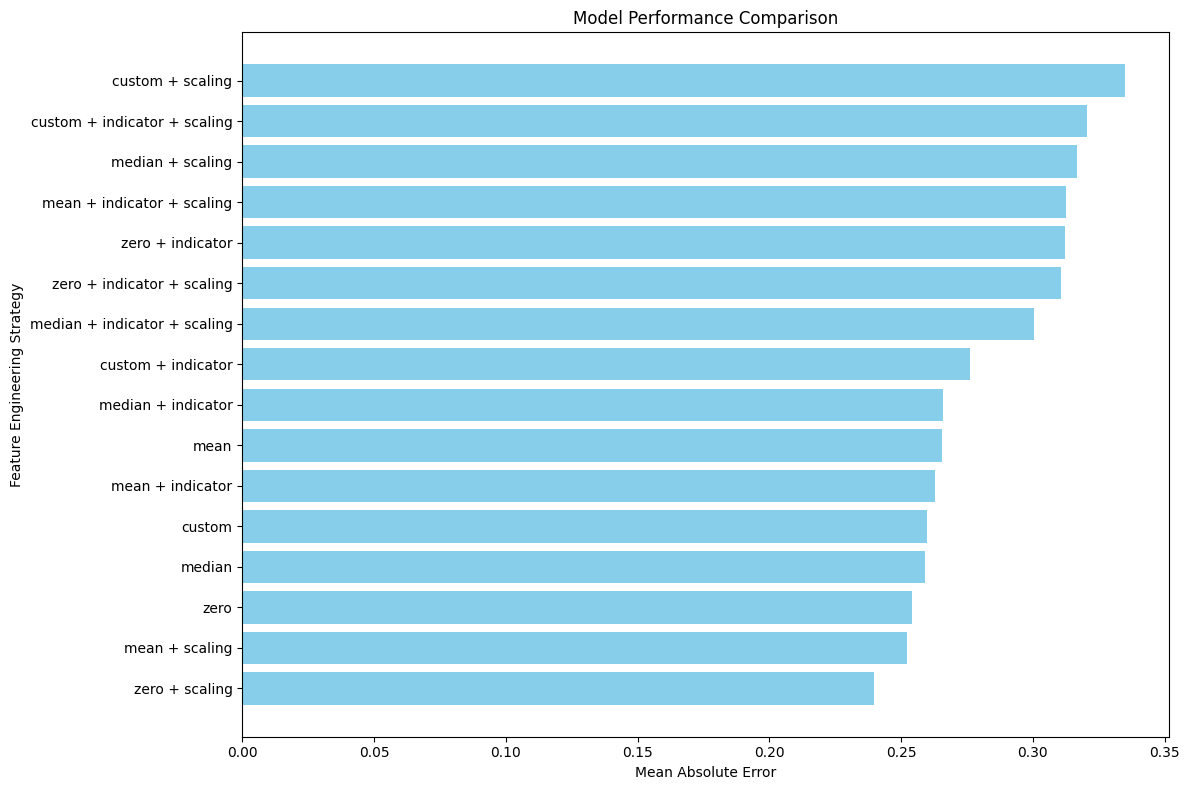

In [9]:
import pandas as pd
import numpy as np
import random
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from pandas.api.types import is_numeric_dtype
import itertools

# Set random seed for NumPy
np.random.seed(42)
# Set random seed for Python's built-in random module
random.seed(42)
# Set random seed for scikit-learn (used for various random processes)
sklearn.utils.check_random_state(42)

one_hot_columns = ["architectural_archetype", "stories", "soil_class", "seismic_zone", "connection_system"]
exclude_columns = ["connection_system_ATS", "connection_system_HD"]

def load_data(file_path):
    return pd.read_csv(file_path, low_memory=False)

def apply_preprocessing_techniques(df, techniques):
    """
    Apply various preprocessing techniques to the DataFrame.

    :param df: DataFrame to process.
    :param techniques: List of preprocessing techniques to apply.
    :return: Processed DataFrame.
    """
    for technique in techniques:
        if technique in strategy_functions:
            df = strategy_functions[technique](df)
    return df

def train_and_evaluate(model, parameters, X_train, X_test, Y_train, Y_test):
    """
    Train the model and evaluate its performance using MAE.

    :param model: The machine learning model.
    :param parameters: Hyperparameters for the model.
    :param X_train, X_test, Y_train, Y_test: Training and testing datasets.
    :return: Mean Absolute Error of the model.
    """
    grid_search = GridSearchCV(model, parameters, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, Y_train)
    Y_pred = grid_search.predict(X_test)
    return mean_absolute_error(Y_test, Y_pred)

def plot_mae_results(results, name):
    """
    Plot the Mean Absolute Error results in a sorted horizontal bar chart.

    :param results: Dictionary containing the feature engineering strategies and their MAEs.
    """
    plt.figure(figsize=(12, 8))

    # Sort the results for better visualization
    sorted_results = dict(sorted(results.items(), key=lambda item: item[1]))

    # Create a horizontal bar chart
    plt.barh(list(sorted_results.keys()), list(sorted_results.values()), color='skyblue')
    plt.xlabel('Mean Absolute Error')
    plt.ylabel('Feature Engineering Strategy')
    plt.title('Model Performance Comparison')

    # Adjust layout to accommodate longer strategy names
    plt.tight_layout()

    save_dir = './Files/Visualisation/Feature_Engineering/'
    # Save the plot before showing
    plt.savefig(save_dir + 'mae_comparison_sorted' + name + '.png')
    plt.show()



# Modify the strategy_functions to include lambda functions for techniques requiring additional parameters
strategy_functions = {
    'median': lambda df: impute_with_median(df),
    'mean': lambda df: impute_with_mean(df),
    'zero': lambda df: impute_with_zero(df),
    'custom': lambda df: custom_imputation(df),
    'indicator': lambda df: creating_indicator_variables(df),
    'scaling': lambda df: scale_columns(df, MinMaxScaler(), determine_columns_to_scale(df, one_hot_columns)),
    'correlation': lambda df: remove_highly_correlated_column(df, exclude_columns),
    'variance' : lambda df: remove_column_with_zero_variance(df),
    'ratio' : lambda df: remove_column_with_high_ratio(df, exclude_columns)
}



path = './Files/Before_Feature_Engineering/data_D.csv'
df = load_data(path)
target_columns = ['Ωx', 'Ωy', 'µx', 'µy', 'CMR', 'SSF', 'ACMR', 'IO-ln θ', 'IO-β', 'LS-ln θ', 'LS-β', 'CP-ln θ', 'CP-β']

model = RandomForestRegressor()
parameters = {'n_estimators': [20]}
df_encoded, _ = one_hot_encode_columns(df, one_hot_columns)

# Define preprocessing strategies
imputation_strategies = ['median', 'mean', 'zero', 'custom']
other_strategies = ['indicator', 'scaling']

# Generate combinations
all_combinations = []
for imp_strategy in imputation_strategies:
    for r in range(len(other_strategies) + 1):
        for combo in itertools.combinations(other_strategies, r):
            all_combinations.append((imp_strategy,) + combo)

performance_results = {}

for techniques in all_combinations:
    X = df_encoded.drop(target_columns, axis=1)
    Y = df_encoded[target_columns]
    X = apply_preprocessing_techniques(X.copy(), techniques)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
    mae = train_and_evaluate(model, parameters, X_train, X_test, Y_train, Y_test)
    performance_results[' + '.join(techniques)] = mae

plot_mae_results(performance_results, 'nan_values')

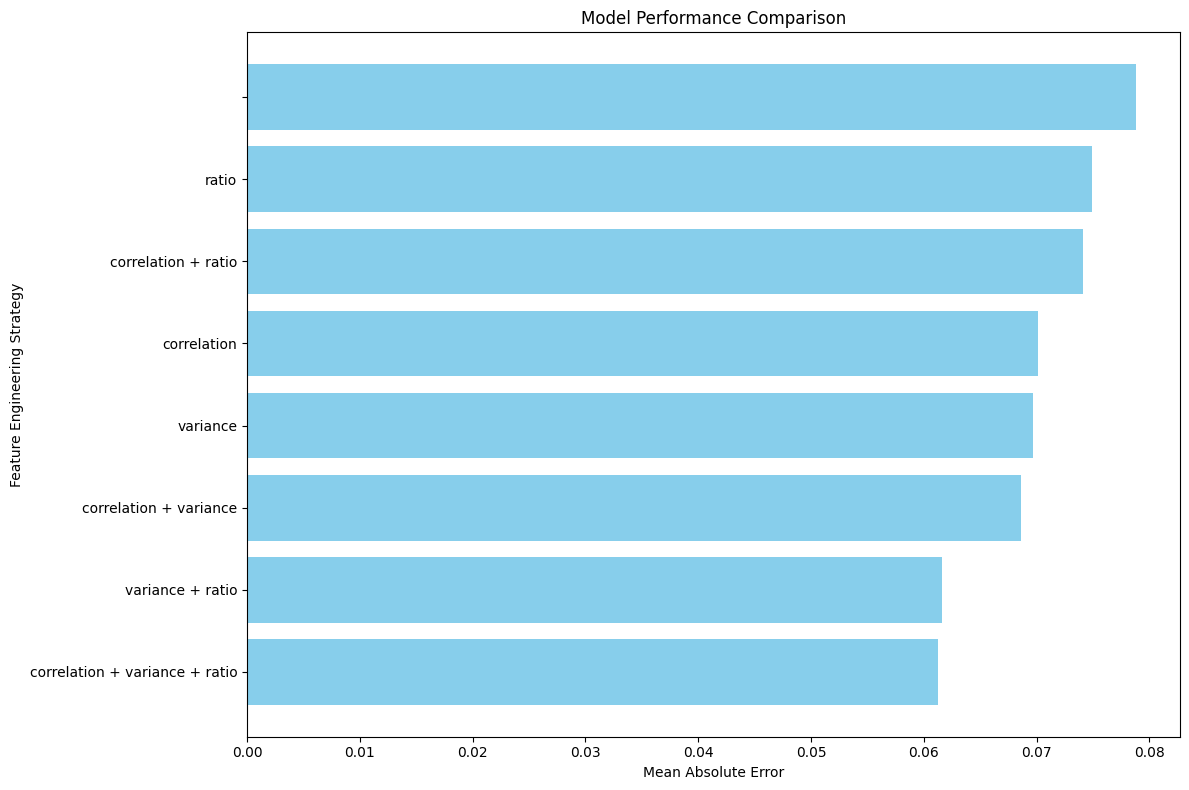

In [17]:
df_encoded_after = impute_with_zero(df_encoded)
df_encoded_after = scale_columns(df_encoded_after, MinMaxScaler(), determine_columns_to_scale(df_encoded_after, one_hot_columns))

other_strategies2 = ['correlation', 'variance', 'ratio']
# Generate combinations
all_combinations2 = []
for r in range(len(other_strategies2) + 1):
        for combo in itertools.combinations(other_strategies2, r):
            all_combinations2.append(combo)
            
performance_results = {}

for techniques in all_combinations2:
    X = df_encoded_after.drop(target_columns, axis=1)
    Y = df_encoded_after[target_columns]
    X = apply_preprocessing_techniques(X.copy(), techniques)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
    mae = train_and_evaluate(model, parameters, X_train, X_test, Y_train, Y_test)
    performance_results[' + '.join(techniques)] = mae

plot_mae_results(performance_results, 'feature_selec')